<h2 style="color:blue" align="center">Deep Neural Network (DNN) for Classification on MNIST</h2>

#### Import the necessary libraries

In [12]:
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import Callback, CSVLogger 

#### Load and split the dataset into training and testing set

MNIST - Handwritten digits recognition

In [13]:
#(X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()

MNIST - Fashion dataset

In [14]:
(X_train,y_train),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()

#### Flattening

In [15]:
X_train_flattened = X_train.reshape(len(X_train), 28 * 28)
X_test_flattened = X_test.reshape(len(X_test),  28 * 28) 

#### Normalize the input dataset

In [16]:
X_train_normalized = X_train_flattened / 255
X_test_normalized = X_test_flattened / 255

#### Define DNN model

In [17]:
python_random.seed(3)
np.random.seed(7)
tf.random.set_seed(13)
opti_name = ''

def get_model(): 
    model = Sequential([
        # input layer 784 neurons to first hidden layer with 64 neurons
        Dense(256, input_shape = (784,), activation='relu'), 
        # first hidden layer to second hidden layer
        Dense(64, activation='relu'),  
        # Output layer with 10 neurons  
        Dense(10, activation='softmax') 
    ])
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.01)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.01, momentum=0.6)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.01, momentum=0.6, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.6)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax'
    
    model.compile(
        optimizer = opti,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [18]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):   
    # Training stop criteria
    stop_at = 0.99
    
    def on_epoch_end(self, epoch, logs={}):
        global generic_best
        acc = round(logs.get('accuracy'), 4)  
        
        if epoch == 0:
            generic_best = acc             
        
        if epoch > 0 and acc > generic_best :
            generic_best = acc  
            
        if(acc > self.stop_at):  
            self.model.stop_training = True 

For HM based optimizer model

In [19]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0     
    r = 1
    # r=0 no HM based, r=1 HM based
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  

    def on_epoch_end(self, epoch, logs={}): 
         # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(num_layers):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i*2])
            tensor2 = tf.convert_to_tensor(current_weights[i*2])
            current_weights[i*2] = self.call_hm(tensor1, tensor2)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        
        # Stopping criteria
        if(round(logs.get('accuracy'), 4) > generic_best): 
            self.model.stop_training = True
        
    def apply_hm(self, v1, v2):     
        if v1==0 or v2==0:
            return v2
        elif v1>0 and v2>0:
            hm = 2*v1*v2/(v1+v2)
            min1 = min(v1,v2)
            diff = abs(hm-min1) * self.r
            if v2 > v1:
                return v2 + diff
            else:
                return v2 - diff
        elif v1<0 and v2<0:
            hm = 2*v1*v2/(v1+v2)
            max1 = max(v1,v2)
            diff = abs(hm-max1) * self.r
            if v2 > v1:
                return v2 + diff
            else:
                return v2 - diff
        else:
            return v2  

To record loss and accuracy in CSV file

In [20]:
logger_generic_model = CSVLogger('2.Generic_model_MNIST.csv', append = False, separator=',')
logger_hm_model = CSVLogger('2.HM_model_MNIST.csv', append = False, separator=',')

#### Training

Get a model to assign same weights to model with and without HM

In [22]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 200

Generic optimizer model

In [23]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time() 
model_wihtout_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size = X_train.shape[0]) 
et = time.time()
elapsed_time = round(et - st, 4)
print('Execution time:', elapsed_time, 'seconds')
print('\nGeneric optimizer best Accuracy is :', generic_best)

Epoch 1/200
1/1 [==============================] - 1s 989ms/step - loss: 2.5639 - accuracy: 0.1000
Epoch 2/200
1/1 [==============================] - 0s 325ms/step - loss: 2.1886 - accuracy: 0.2672
Epoch 3/200
1/1 [==============================] - 0s 321ms/step - loss: 2.0306 - accuracy: 0.3119
Epoch 4/200
1/1 [==============================] - 0s 348ms/step - loss: 1.8797 - accuracy: 0.3948
Epoch 5/200
1/1 [==============================] - 0s 383ms/step - loss: 1.7269 - accuracy: 0.4716
Epoch 6/200
1/1 [==============================] - 0s 368ms/step - loss: 1.5807 - accuracy: 0.5486
Epoch 7/200
1/1 [==============================] - 0s 347ms/step - loss: 1.4485 - accuracy: 0.5973
Epoch 8/200
1/1 [==============================] - 0s 355ms/step - loss: 1.3378 - accuracy: 0.6173
Epoch 9/200
1/1 [==============================] - 0s 470ms/step - loss: 1.2495 - accuracy: 0.6302
Epoch 10/200
1/1 [==============================] - 0s 391ms/step - loss: 1.1726 - accuracy: 0.6427
Epoch 11/

1/1 [==============================] - 0s 294ms/step - loss: 0.4013 - accuracy: 0.8601
Epoch 84/200
1/1 [==============================] - 0s 308ms/step - loss: 0.3998 - accuracy: 0.8607
Epoch 85/200
1/1 [==============================] - 0s 309ms/step - loss: 0.3983 - accuracy: 0.8611
Epoch 86/200
1/1 [==============================] - 0s 348ms/step - loss: 0.3975 - accuracy: 0.8622
Epoch 87/200
1/1 [==============================] - 0s 317ms/step - loss: 0.3976 - accuracy: 0.8606
Epoch 88/200
1/1 [==============================] - 0s 290ms/step - loss: 0.3986 - accuracy: 0.8623
Epoch 89/200
1/1 [==============================] - 0s 312ms/step - loss: 0.3967 - accuracy: 0.8606
Epoch 90/200
1/1 [==============================] - 0s 301ms/step - loss: 0.3922 - accuracy: 0.8640
Epoch 91/200
1/1 [==============================] - 0s 319ms/step - loss: 0.3897 - accuracy: 0.8645
Epoch 92/200
1/1 [==============================] - 0s 293ms/step - loss: 0.3906 - accuracy: 0.8632
Epoch 93/200


HM based optimizer model

In [24]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size = X_train.shape[0]) 
et = time.time()
elapsed_time = round(et - st, 4)
print('Execution time:', elapsed_time, 'seconds')

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.5639 - accuracy: 0.1000
Epoch 2/200
1/1 [==============================] - 1s 526ms/step - loss: 2.1754 - accuracy: 0.2388
Epoch 3/200
1/1 [==============================] - 1s 548ms/step - loss: 1.9656 - accuracy: 0.3594
Epoch 4/200
1/1 [==============================] - 1s 695ms/step - loss: 1.7613 - accuracy: 0.4599
Epoch 5/200
1/1 [==============================] - 1s 690ms/step - loss: 1.5687 - accuracy: 0.5603
Epoch 6/200
1/1 [==============================] - 1s 550ms/step - loss: 1.4018 - accuracy: 0.6065
Epoch 7/200
1/1 [==============================] - 1s 546ms/step - loss: 1.2719 - accuracy: 0.6241
Epoch 8/200
1/1 [==============================] - 1s 531ms/step - loss: 1.1705 - accuracy: 0.6390
Epoch 9/200
1/1 [==============================] - 1s 563ms/step - loss: 1.0868 - accuracy: 0.6532
Epoch 10/200
1/1 [==============================] - 1s 628ms/step - loss: 1.0177 - accuracy: 0.6602
Epoch 11/200

1/1 [==============================] - 0s 495ms/step - loss: 0.3849 - accuracy: 0.8676
Epoch 84/200
1/1 [==============================] - 1s 517ms/step - loss: 0.3832 - accuracy: 0.8666
Epoch 85/200
1/1 [==============================] - 1s 515ms/step - loss: 0.3815 - accuracy: 0.8682
Epoch 86/200
1/1 [==============================] - 1s 605ms/step - loss: 0.3802 - accuracy: 0.8680
Epoch 87/200
1/1 [==============================] - 1s 508ms/step - loss: 0.3792 - accuracy: 0.8686
Epoch 88/200
1/1 [==============================] - 1s 546ms/step - loss: 0.3781 - accuracy: 0.8686
Epoch 89/200
1/1 [==============================] - 1s 547ms/step - loss: 0.3765 - accuracy: 0.8698
Epoch 90/200
1/1 [==============================] - 1s 503ms/step - loss: 0.3751 - accuracy: 0.8692
Epoch 91/200
1/1 [==============================] - 1s 517ms/step - loss: 0.3738 - accuracy: 0.8706
Epoch 92/200
1/1 [==============================] - 0s 478ms/step - loss: 0.3721 - accuracy: 0.8701
Epoch 93/200


Model summary

In [25]:
model_hm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               200960    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 10)                650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


#### Generic optimizer vs HM-based optimizer

In [26]:
df1 = pd.read_csv("2.Generic_model_MNIST.csv")
df2 = pd.read_csv("2.HM_model_MNIST.csv")

Accuracy

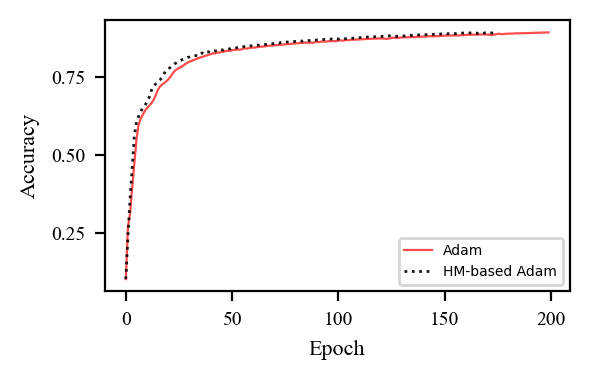

In [27]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['accuracy'] 
y2 = df2['accuracy']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Accuracy' , fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xlabel('Epoch', fontdict = {'fontname':'Times New Roman', 'fontsize':8})
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 7, fontname = 'Times New Roman')
plt.yticks(fontsize = 7, fontname = 'Times New Roman')
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

Loss

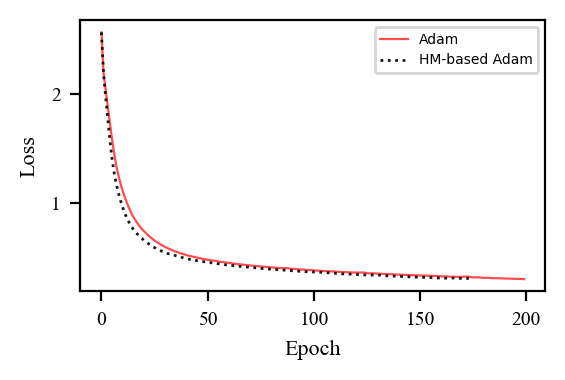

In [28]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xlabel('Epoch', fontdict = {'fontname':'Times New Roman', 'fontsize':8})
#plt.title("MAE", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 7, fontname = 'Times New Roman')
plt.yticks(fontsize = 7, fontname = 'Times New Roman')
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

###### Testing the model

Generic opimizer model

In [29]:
model_wihtout_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.3596 - accuracy: 0.8731


[0.359601765871048, 0.8730999827384949]

HM based optimizer model

In [30]:
model_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.3619 - accuracy: 0.8718


[0.3619125485420227, 0.8718000054359436]